In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

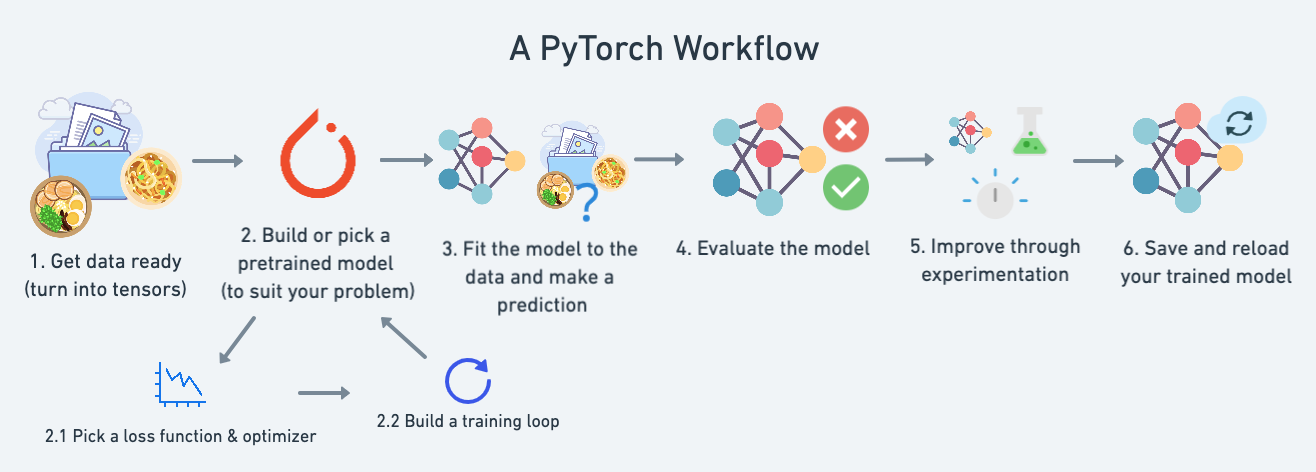

In [2]:
being_covered_here = {1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}

## 1. Data prep and loading

In [3]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)

y = weight*X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
train_split = int(0.8 * len(X))

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [5]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

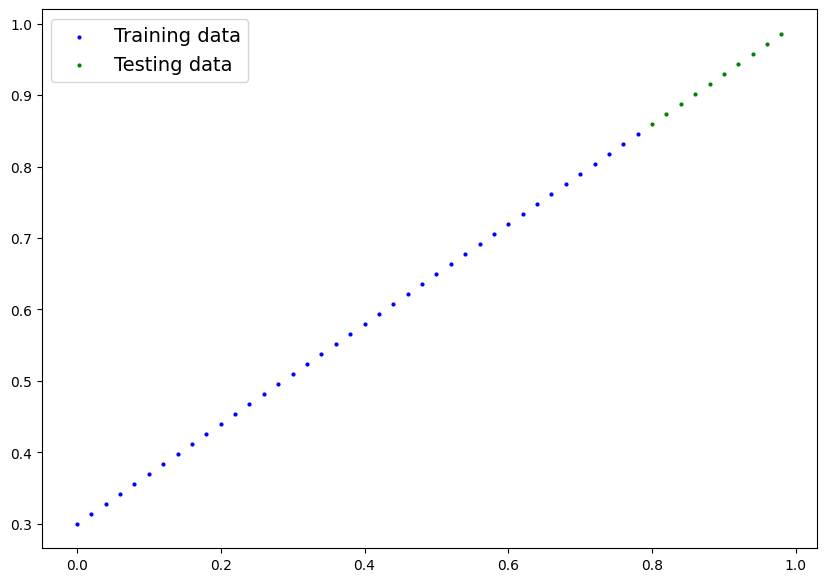

In [6]:
plot_predictions()

In [7]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__() 
        self.weights = nn.Parameter(
            torch.randn(1, dtype=torch.float),
            requires_grad=True)

        self.bias = nn.Parameter(
            torch.randn(1, dtype=torch.float),
            requires_grad=True)

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

##### Before I continue with the code plus the explanation, let me practice some class concepts [here](./learning_classes.py).


In [8]:
torch.manual_seed(42)

model_0 = LinearRegressionModel()

list(model_0.parameters()), model_0.state_dict()

([Parameter containing:
  tensor([0.3367], requires_grad=True),
  Parameter containing:
  tensor([0.1288], requires_grad=True)],
 OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))]))

In [9]:
with torch.inference_mode(): # or torch.no_grad()
    y_preds = model_0(X_test)

In [10]:
# Checking the predictions
print(f"Number of testing samples: {len(X_test)}") 
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


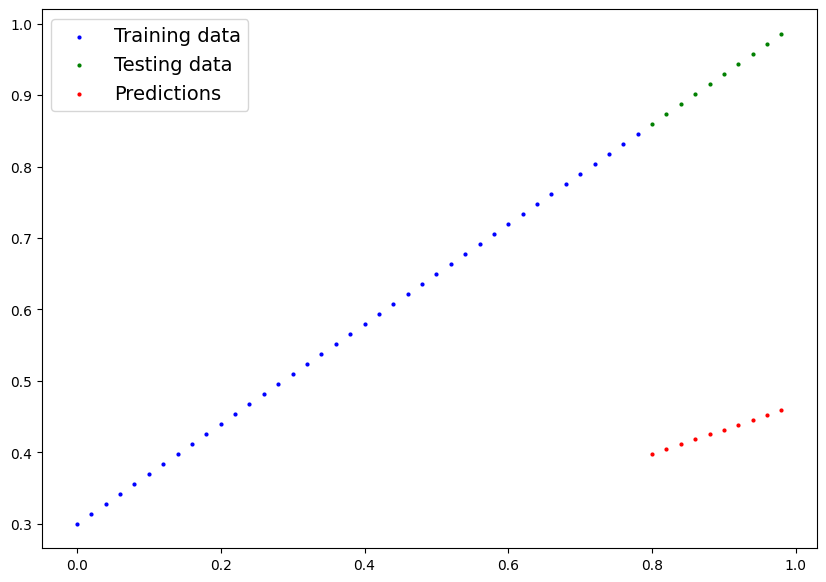

In [11]:
plot_predictions(predictions=y_preds)

In [12]:
y_test - y_preds

tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])

## Training the model

In [13]:
loss_fn = nn.L1Loss() # this is mean-absolute error in torch
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

In [14]:
torch.manual_seed(42)

epochs = 100

train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    # ==================== training ======================
    model_0.train()
    y_pred = model_0(X_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # ==================== testing =======================
    model_0.eval()
    with torch.inference_mode():
        test_pred = model_0(X_test)
        test_loss = loss_fn(test_pred, y_test.type(torch.float32))
    
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        train_loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495 
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428 
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688 
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703 
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106 
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024 
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135 
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519 
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484 
Epoch: 90 | MAE Train Loss: 0.02788740023970604 | MAE Test Loss: 0.06473556160926819 


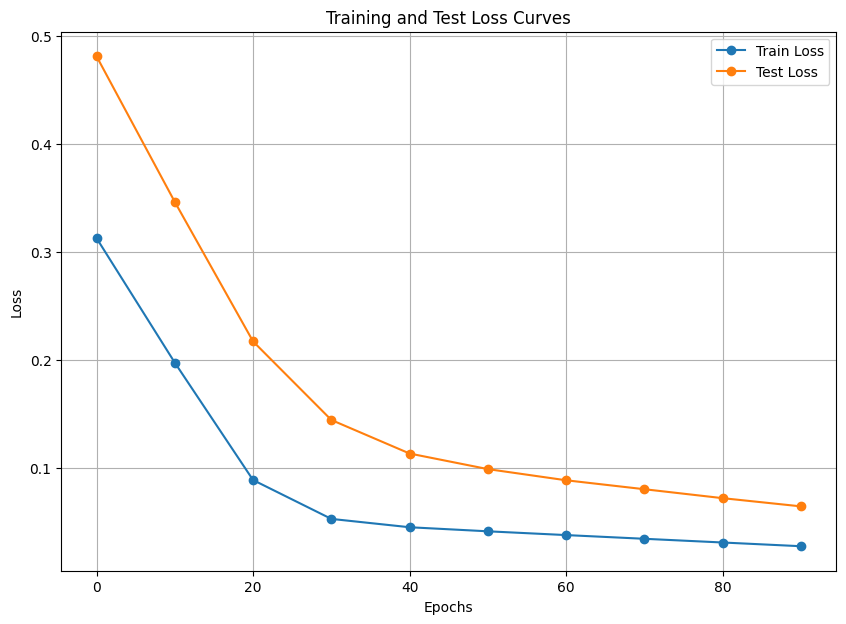

In [18]:
plt.figure(figsize=(10, 7))

# Convert tensors to numpy arrays if needed
train_loss_values = [loss.item() for loss in train_loss_values]
test_loss_values = [loss.item() for loss in test_loss_values]

plt.plot(epoch_count, train_loss_values, label="Train Loss", marker='o')
plt.plot(epoch_count, test_loss_values, label="Test Loss", marker='o')
plt.title("Training and Test Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.grid(True)
plt.show()